# btlflt.ipynb

There is much interest in using insect wimgbeat waveforms for automated monitoring of insect flight activity. [Perform a Google search for "insect wingbeat waveform"](https://www.google.com/search?client=ubuntu&channel=fs&q=insect+wingbeat+harmonics#vhid=RcBJqwjT8KH1GM&vssid=l) to see what I mean. 

Wingbeat waveforms can be recorded acoustically using a microphone, or optically using a photosensor. 

Here is the waveform and frequency spectrum of a mosquito I recorded way back in 1984 using a photodiode:

<img src="../images/example_waveform.png" width = "500px">

From [Moore, A. 1991. Artificial neural network trained to identify mosquitoes in flight.](https://www.researchgate.net/publication/226904676_Artificial_neural_network_trained_to_identify_mosquitoes_in_flight)

As you can see, spectral analysis of an insect wingbeat waveforms reveals that it contains a harmonic series consisting of the wingbeat frequency plus harmonics occurring at integer multiples of the wingbeat frequency.

I suggested that automated instrumentation could be developed to identify species of flying insects by recognizing spectral patterns formed by harmonics in much the same way in which the human brain and ear identifies musical instruments by recognizing distinct harmonic patterns in the sounds they produce (Moore, A. 1986).

Ever since doing this research 40 years ago, I have wondered about the origin of harmonics in optically recorded insect wingbeat waveforms. Here is an unpublished chart I made to help figure this out:

<img src="../images/waveform_chart.png">

1. Changes in reflective area of the insect during the wingbeat cycle. For example, occlusion of the wings by the thorax and abdomen.
2. Specular reflections from shiny parts of the insect such as wing membranes.
3. Phantom harmonics which are an artifact of the Fast Fourier Transform. 

In [1]:
import btlflt as bf

In [2]:
# Note: ```.gitignore``` includes VIDEOPATH and FRAMESDIR

VIDEO_PATH = 'video.mp4'                # path to video file of beetles in flight downloaded from YouTube
FRAMES_DIR = 'frames'                   # directory containing all frames extracted from VIDEO_PATH

SCENE_ID = 'F1-718'                     # identifier for scene being analyzed
FIRST_FRAME_NUM = 1                     # first frame number in scene 
LAST_FRAME_NUM = 718                    # last frame number in scene
SAMPLE_RATE = 6000                      # Original sample rate for the scene in frames per second

FIGURES_DIR = f'{SCENE_ID}/figures'     # figures generated by bf.create_frame_intensity_figure
FIGURES_VIDEO = f'{SCENE_ID}/video.mp4' # path to video file of figures generated by bf.create_frame_intensity_figure

# MAIN PROGRAM

In [3]:
# Step 1: Download the YouTube video (best quality, no audio)

if bf.os.path.exists(VIDEO_PATH):
    print(f'VIDEO_PATH ({VIDEO_PATH}) already exists')
else:
    command = f'yt-dlp -o {VIDEO_PATH} -f bestvideo https://www.youtube.com/watch?v=IUQSZHr9h9Q'
    bf.os.system(command)

VIDEO_PATH (video.mp4) already exists


In [4]:
# Step 2: Extract frames from the video

bf.video2frames(VIDEO_PATH, FRAMES_DIR)

Images directory frames already exists. Skipping video2frames conversion.


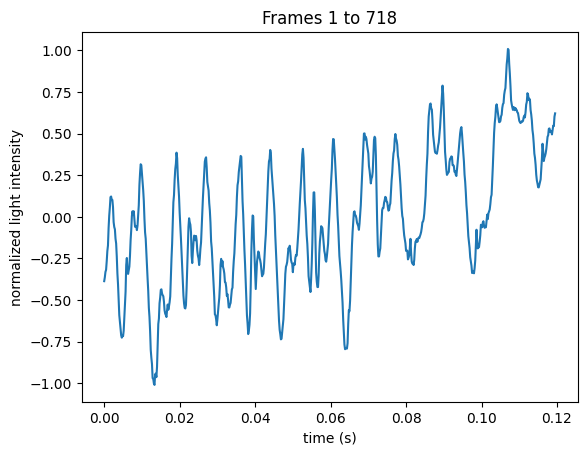

In [5]:
# Step 3: Calculate time and light intensity for each frame

# create seconds_list which will be used for the x axis
seconds_list = [i/SAMPLE_RATE for i in range(LAST_FRAME_NUM)]

# create intensity_list which will be used for the y axis
intensity_list = bf.calc_intensity_time_series(FRAMES_DIR, FIRST_FRAME_NUM, LAST_FRAME_NUM)

# plot results
bf.plt.plot(seconds_list, intensity_list)
bf.plt.title(f"Frames {FIRST_FRAME_NUM} to {LAST_FRAME_NUM}")
bf.plt.xlabel("time (s)")
bf.plt.ylabel("normalized light intensity")

# Create WAV file, save it and provide an audio player
bf.create_wav_file(filename='intensity_timeseries.wav', data=intensity_list, framerate=SAMPLE_RATE)
bf.Audio('intensity_timeseries.wav')

<audio src='intensity_timeseries.wav'></audio>

In [6]:
# Step 4: Make figures to visualize the relationship between an image sequence and the wingbeat waveform

# Create a video from the frames
if bf.os.path.exists(FIGURES_DIR):
    print(f'FIGURES_DIR ({FIGURES_DIR}) already exists. Skipping.')
else:
    bf.os.makedirs(FIGURES_DIR)
    for frame_num in range(FIRST_FRAME_NUM, LAST_FRAME_NUM + 1):
        bf.create_frame_intensity_figure(
            frame_num,
            seconds_list, 
            intensity_list, 
            frame_path = f'{FRAMES_DIR}/{frame_num:04d}.png', 
            fig_path = f'{FIGURES_DIR}/{frame_num:04d}.png'
        )

FIGURES_DIR (F1-718/figures) already exists. Skipping.


In [7]:
# Step 5: Create a video from the figures

bf.frames2video(FIGURES_DIR, FIGURES_VIDEO)

# Provide a video player
bf.Video(FIGURES_VIDEO)

Video file F1-718/video.mp4 already exists. Skipping frames2video conversion.


In [8]:
# Step 6: Estimate the harmonic frequencies

# Signal conditioning

# Apply Butterworth bandpass filter to suppress frequencies below 30 Hz and greater than 2000 Hz.
filtered_data = bf.butter_bandpass_filter(data=intensity_list, lowcut=30, highcut=2000, fs=SAMPLE_RATE, order=6)
# Apply a Hanning window to taper the amplitude to zero at both ends.
windowed_filtered_data = bf.np.hanning(len(filtered_data)) * filtered_data

# Estimate the wingbeat frequency from the conditioned signal
wbf = bf.freq_from_autocorr(windowed_filtered_data, SAMPLE_RATE)

# Calculate the first 10 harmonic frequencies
harmonic_frequencies = [i * wbf for i in range(1, 11)]
for i in range(10):
    print(f'f{i}: {harmonic_frequencies[i]:.1f} Hz')  

f0: 59.9 Hz
f1: 119.9 Hz
f2: 179.8 Hz
f3: 239.8 Hz
f4: 299.7 Hz
f5: 359.7 Hz
f6: 419.6 Hz
f7: 479.6 Hz
f8: 539.5 Hz
f9: 599.5 Hz


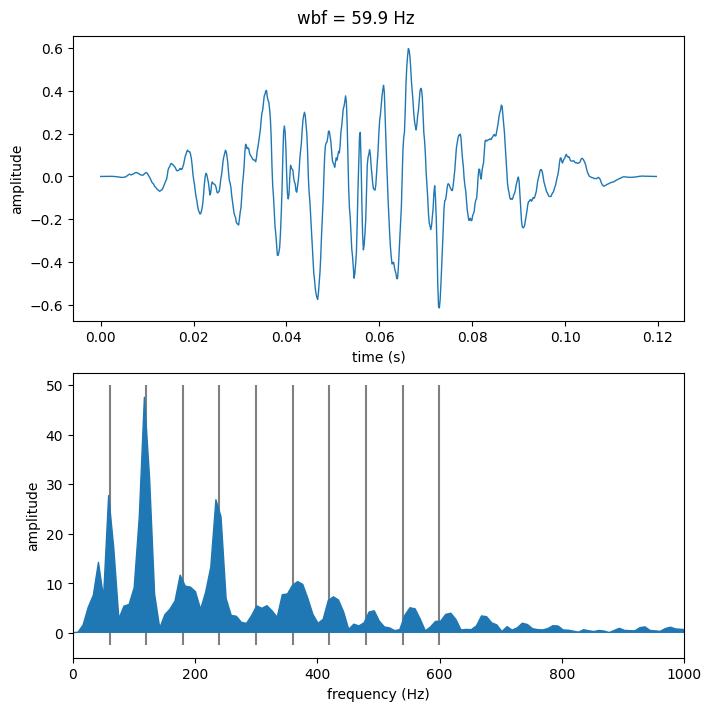

In [9]:
# Step 7: Perform a Fourier transform to estimate the frequency spectrum

# Plot the conditioned signal
fig, (axt, axf) = bf.plot_time_frequency(SAMPLE_RATE, windowed_filtered_data)

# Modify the figure to show the first 10 harmonic frequencies

# Limit the frequency range to 1000 Hz
axf.set_xlim(0, 1000)
# Set the zorder of the harmonic frequency lines to 0 so that the will be behind the spectrogram (zorder=1)
axf.set_zorder(1)
ymin, ymax = axf.get_ylim()
axf.vlines(x=harmonic_frequencies, ymin=ymin, ymax=ymax, color='gray', zorder=0)
# Display the wingbeat frequency in the title
fig.suptitle(f'wbf = {wbf:.1f} Hz')
fig

# Create WAV file, save it and provide an audio player
bf.create_wav_file(filename='windowed_filtered_data.wav', data=windowed_filtered_data, framerate=SAMPLE_RATE)
bf.Audio('windowed_filtered_data.wav')

### Finished

In [16]:
def remove_background(input_image_path:str, output_image_path:str, lo_thresh:int=140, hi_thresh:int=255)->None: 
    """ 
    Remove the background from an image using a binary threshold and saves in output_image_path.
    """
    image = cv2.imread(input_image_path)

    # Convert the image to RGB (OpenCV loads images in BGR format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

    # Apply a binary threshold to the image
    _, binary = cv2.threshold(gray, lo_thresh, hi_thresh, cv2.THRESH_BINARY_INV)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask with the same dimensions as the image, filled with zeros (black)
    mask = np.zeros_like(image_rgb)

    # Draw the contours on the mask
    cv2.drawContours(mask, contours, -1, (255, 255, 255), thickness=cv2.FILLED)

    # Bitwise-and the mask and the original image
    result = cv2.bitwise_and(image_rgb, mask)
    
    cv2.imwrite(output_image_path, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))